In [100]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

In [101]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [102]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [103]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


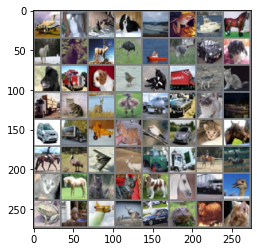

plane cat   cat   dog   ship  frog  ship  horse horse horse deer  bird  ship  dog   car   dog   dog   truck dog   bird  cat   truck deer  cat   truck cat   deer  bird  plane car   cat   ship  car   truck plane cat   bird  car   cat   horse horse bird  plane deer  truck truck horse horse cat   horse cat   cat   dog   horse truck bird  frog  dog   plane deer  car   frog  cat   cat  


In [104]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [105]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [106]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.001,momentum = 0):
    history = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [107]:
begin = time.time()
history, end = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:09<00:00, 67.84it/s]


Epoch [0], Time taken :11.7842, train_loss : 2.3014, train_acc: 0.1063, val_loss: 2.2993, val_acc: 0.1086


100%|██████████| 657/657 [00:10<00:00, 62.03it/s]


Epoch [1], Time taken :12.4064, train_loss : 2.2968, train_acc: 0.1184, val_loss: 2.2942, val_acc: 0.1290


100%|██████████| 657/657 [00:09<00:00, 67.41it/s]


Epoch [2], Time taken :11.5230, train_loss : 2.2910, train_acc: 0.1341, val_loss: 2.2870, val_acc: 0.1460


100%|██████████| 657/657 [00:10<00:00, 64.45it/s]


Epoch [3], Time taken :12.7762, train_loss : 2.2820, train_acc: 0.1585, val_loss: 2.2772, val_acc: 0.1628


100%|██████████| 657/657 [00:10<00:00, 63.56it/s]


Epoch [4], Time taken :12.1539, train_loss : 2.2670, train_acc: 0.1838, val_loss: 2.2565, val_acc: 0.1966


100%|██████████| 657/657 [00:09<00:00, 66.33it/s]


Epoch [5], Time taken :11.6452, train_loss : 2.2415, train_acc: 0.1984, val_loss: 2.2229, val_acc: 0.2096


100%|██████████| 657/657 [00:10<00:00, 61.33it/s]


Epoch [6], Time taken :12.5316, train_loss : 2.2022, train_acc: 0.2075, val_loss: 2.1800, val_acc: 0.2097


100%|██████████| 657/657 [00:09<00:00, 65.88it/s]


Epoch [7], Time taken :11.8345, train_loss : 2.1614, train_acc: 0.2160, val_loss: 2.1438, val_acc: 0.2150


100%|██████████| 657/657 [00:10<00:00, 64.35it/s]


Epoch [8], Time taken :12.0874, train_loss : 2.1280, train_acc: 0.2221, val_loss: 2.1141, val_acc: 0.2260


100%|██████████| 657/657 [00:10<00:00, 63.55it/s]


Epoch [9], Time taken :12.4131, train_loss : 2.1006, train_acc: 0.2323, val_loss: 2.0893, val_acc: 0.2327


100%|██████████| 657/657 [00:09<00:00, 68.08it/s]


Epoch [10], Time taken :11.6890, train_loss : 2.0788, train_acc: 0.2365, val_loss: 2.0662, val_acc: 0.2412


100%|██████████| 657/657 [00:09<00:00, 67.82it/s]


Epoch [11], Time taken :11.5393, train_loss : 2.0592, train_acc: 0.2410, val_loss: 2.0485, val_acc: 0.2479


100%|██████████| 657/657 [00:10<00:00, 62.09it/s]


Epoch [12], Time taken :12.4073, train_loss : 2.0430, train_acc: 0.2450, val_loss: 2.0342, val_acc: 0.2509


100%|██████████| 657/657 [00:10<00:00, 65.36it/s]


Epoch [13], Time taken :11.8069, train_loss : 2.0264, train_acc: 0.2535, val_loss: 2.0304, val_acc: 0.2535


100%|██████████| 657/657 [00:10<00:00, 60.85it/s]


Epoch [14], Time taken :12.6603, train_loss : 2.0149, train_acc: 0.2562, val_loss: 2.0147, val_acc: 0.2539


100%|██████████| 657/657 [00:10<00:00, 63.13it/s]


Epoch [15], Time taken :12.2028, train_loss : 2.0061, train_acc: 0.2611, val_loss: 2.0062, val_acc: 0.2625


100%|██████████| 657/657 [00:09<00:00, 66.03it/s]


Epoch [16], Time taken :11.7455, train_loss : 1.9967, train_acc: 0.2651, val_loss: 1.9940, val_acc: 0.2670


100%|██████████| 657/657 [00:10<00:00, 62.00it/s]


Epoch [17], Time taken :12.4026, train_loss : 1.9834, train_acc: 0.2726, val_loss: 1.9918, val_acc: 0.2639


100%|██████████| 657/657 [00:10<00:00, 65.08it/s]


Epoch [18], Time taken :12.1355, train_loss : 1.9755, train_acc: 0.2765, val_loss: 1.9783, val_acc: 0.2706


100%|██████████| 657/657 [00:09<00:00, 66.72it/s]


Epoch [19], Time taken :12.1469, train_loss : 1.9656, train_acc: 0.2818, val_loss: 1.9669, val_acc: 0.2796


100%|██████████| 657/657 [00:10<00:00, 60.75it/s]


Epoch [20], Time taken :12.6158, train_loss : 1.9594, train_acc: 0.2835, val_loss: 1.9582, val_acc: 0.2895


100%|██████████| 657/657 [00:10<00:00, 63.92it/s]


Epoch [21], Time taken :12.0198, train_loss : 1.9480, train_acc: 0.2939, val_loss: 1.9532, val_acc: 0.2905


100%|██████████| 657/657 [00:10<00:00, 63.86it/s]


Epoch [22], Time taken :12.4580, train_loss : 1.9387, train_acc: 0.2957, val_loss: 1.9396, val_acc: 0.2959


100%|██████████| 657/657 [00:09<00:00, 66.92it/s]


Epoch [23], Time taken :11.6666, train_loss : 1.9262, train_acc: 0.2999, val_loss: 1.9344, val_acc: 0.3013


100%|██████████| 657/657 [00:10<00:00, 65.03it/s]


Epoch [24], Time taken :11.9450, train_loss : 1.9187, train_acc: 0.3060, val_loss: 1.9218, val_acc: 0.3030


100%|██████████| 657/657 [00:10<00:00, 61.61it/s]


Epoch [25], Time taken :12.4636, train_loss : 1.9070, train_acc: 0.3103, val_loss: 1.9124, val_acc: 0.3160


100%|██████████| 657/657 [00:10<00:00, 65.56it/s]


Epoch [26], Time taken :11.8917, train_loss : 1.8933, train_acc: 0.3170, val_loss: 1.9002, val_acc: 0.3174


100%|██████████| 657/657 [00:10<00:00, 65.14it/s]


Epoch [27], Time taken :11.9073, train_loss : 1.8809, train_acc: 0.3251, val_loss: 1.8853, val_acc: 0.3236


100%|██████████| 657/657 [00:10<00:00, 61.25it/s]


Epoch [28], Time taken :12.7842, train_loss : 1.8646, train_acc: 0.3299, val_loss: 1.8662, val_acc: 0.3321


100%|██████████| 657/657 [00:09<00:00, 68.82it/s]


Epoch [29], Time taken :11.6254, train_loss : 1.8466, train_acc: 0.3379, val_loss: 1.8488, val_acc: 0.3379
Finished Training in 363.7804582118988secs


In [108]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

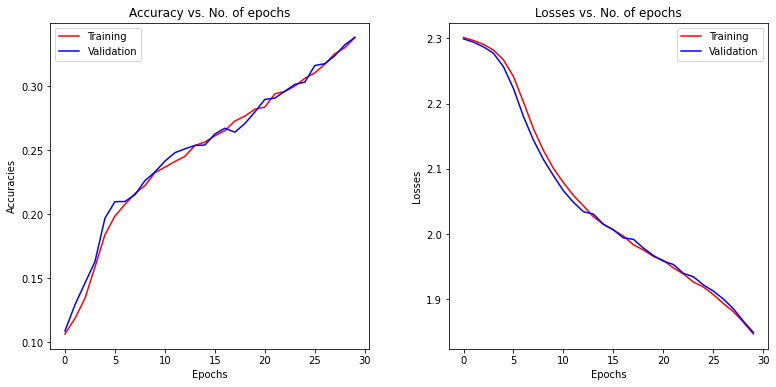

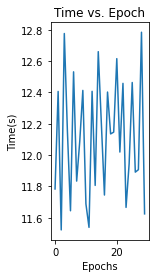

In [109]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(1,3,3)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
              
plot_results(history)

In [110]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [111]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 34 %


In [112]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 45.1 %
Accuracy for class: car   is 41.2 %
Accuracy for class: bird  is 11.4 %
Accuracy for class: cat   is 13.1 %
Accuracy for class: deer  is 21.8 %
Accuracy for class: dog   is 33.1 %
Accuracy for class: frog  is 51.2 %
Accuracy for class: horse is 39.1 %
Accuracy for class: ship  is 45.9 %
Accuracy for class: truck is 45.5 %
